# Seguridad y Privacidad de los Datos - 2024/25

Last edited: 2025/03/25

# 0. Train the model on the provided dataset

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

DATASET_ROUTE = './dataset.csv'

df = pd.read_csv(DATASET_ROUTE)
df.sample(10)

,sha256,label,timestamp,activities_count,providers_count,receivers_count,features_count,intent_filters_count,api_calls_count,urls_count,services_count,unused_permissions,perm_android.permission.ACCESS_ALL_DOWNLOADS,perm_android.permission.ACCESS_BLUETOOTH_SHARE,perm_android.permission.ACCESS_CACHE_FILESYSTEM,perm_android.permission.ACCESS_CHECKIN_PROPERTIES,perm_android.permission.ACCESS_CONTENT_PROVIDERS_EXTERNALLY,perm_android.permission.ACCESS_DOWNLOAD_MANAGER,perm_android.permission.ACCESS_DOWNLOAD_MANAGER_ADVANCED,perm_android.permission.ACCESS_DRM_CERTIFICATES,perm_android.permission.ACCESS_EPHEMERAL_APPS,perm_android.permission.ACCESS_FM_RADIO,perm_android.permission.ACCESS_INPUT_FLINGER,perm_android.permission.ACCESS_KEYGUARD_SECURE_STORAGE,perm_android.permission.ACCESS_LOCATION_EXTRA_COMMANDS,perm_android.permission.ACCESS_MOCK_LOCATION,perm_android.permission.ACCESS_MTP,perm_android.permission.ACCESS_NETWORK_CONDITIONS,perm_android.permission.ACCESS_NETWORK_STATE,perm_android.permission.ACCESS_NOTIFICATIONS,perm_android.permission.ACCESS_NOTIFICATION_POLICY,perm_android.permission.ACCESS_PDB_STATE,perm_android.permission.ACCESS_SURFACE_FLINGER,perm_android.permission.ACCESS_VOICE_INTERACTION_SERVICE,perm_android.permission.ACCESS_VR_MANAGER,perm_android.permission.ACCESS_WIFI_STATE,perm_android.permission.ACCESS_WIMAX_STATE,perm_android.permission.ACCOUNT_MANAGER,perm_android.permission.ALLOW_ANY_CODEC_FOR_PLAYBACK,perm_android.permission.ASEC_ACCESS,perm_android.permission.ASEC_CREATE,perm_android.permission.ASEC_DESTROY,perm_android.permission.ASEC_MOUNT_UNMOUNT,perm_android.permission.ASEC_RENAME,perm_android.permission.AUTHENTICATE_ACCOUNTS,perm_android.permission.BACKUP,perm_android.permission.BATTERY_STATS,perm_android.permission.BIND_ACCESSIBILITY_SERVICE,perm_android.permission.BIND_APPWIDGET,perm_android.permission.BIND_CARRIER_MESSAGING_SERVICE,perm_android.permission.BIND_CARRIER_SERVICES,perm_android.permission.BIND_CHOOSER_TARGET_SERVICE,perm_android.permission.BIND_CONDITION_PROVIDER_SERVICE,perm_android.permission.BIND_CONNECTION_SERVICE,perm_android.permission.BIND_DEVICE_ADMIN,perm_android.permission.BIND_DIRECTORY_SEARCH,perm_android.permission.BIND_DREAM_SERVICE,perm_android.permission.BIND_INCALL_SERVICE,perm_android.permission.BIND_INPUT_METHOD,perm_android.permission.BIND_INTENT_FILTER_VERIFIER,perm_android.permission.BIND_JOB_SERVICE,perm_android.permission.BIND_KEYGUARD_APPWIDGET,perm_android.permission.BIND_MIDI_DEVICE_SERVICE,perm_android.permission.BIND_NFC_SERVICE,perm_android.permission.BIND_NOTIFICATION_LISTENER_SERVICE,perm_android.permission.BIND_NOTIFICATION_RANKER_SERVICE,perm_android.permission.BIND_PACKAGE_VERIFIER,perm_android.permission.BIND_PRINT_RECOMMENDATION_SERVICE,perm_android.permission.BIND_PRINT_SERVICE,perm_android.permission.BIND_PRINT_SPOOLER_SERVICE,perm_android.permission.BIND_QUICK_SETTINGS_TILE,perm_android.permission.BIND_REMOTEVIEWS,perm_android.permission.BIND_REMOTE_DISPLAY,perm_android.permission.BIND_ROUTE_PROVIDER,perm_android.permission.BIND_RUNTIME_PERMISSION_PRESENTER_SERVICE,perm_android.permission.BIND_SCREENING_SERVICE,perm_android.permission.BIND_TELECOM_CONNECTION_SERVICE,perm_android.permission.BIND_TEXT_SERVICE,perm_android.permission.BIND_TRUST_AGENT,perm_android.permission.BIND_TV_INPUT,perm_android.permission.BIND_TV_REMOTE_SERVICE,perm_android.permission.BIND_VOICE_INTERACTION,perm_android.permission.BIND_VPN_SERVICE,perm_android.permission.BIND_VR_LISTENER_SERVICE,perm_android.permission.BIND_WALLPAPER,perm_android.permission.BLUETOOTH,perm_android.permission.BLUETOOTH_ADMIN,perm_android.permission.BLUETOOTH_MAP,perm_android.permission.BLUETOOTH_PRIVILEGED,perm_android.permission.BLUETOOTH_STACK,perm_android.permission.BRICK,perm_android.permission.BROADCAST_NETWORK_PRIVILEGED,perm_android.permission.BROADCAST_PACKAGE_REMOVED,perm_android.permission.BROADCAST_SMS,perm_android.permission.BROADCAST_STICKY,perm_android.permission.BROADCAST_WAP_

Cositas importantes:

* sha256 poco útil
* Ordenar en orden cronológico y dividir el entrenamiento (entrenar con las de hace 5 años y predecir actuales) dice que es interesante
* 'activities_count', 'providers_count','receivers_count' parecen interesantes según él
* 'api_calls_count' interesante
* 'unused_permissions' permisos pedidos pero no usados
* 'urls_count' cuantas urls se han encontrado dentro de la apk
* Probar varios modelos e ir quitando/poniendo caracteristicas
* Hay varias columnas con sus, que son llamadas a la api
* Hay que intentar hacer un modelo no muy bueno al principio para que sea bueno en general

In [3]:
df.columns

Index(['sha256', 'label', 'timestamp', 'activities_count', 'providers_count',
       'receivers_count', 'features_count', 'intent_filters_count',
       'api_calls_count', 'urls_count',
       ...
       'susp_getNetworkCountryIso', 'susp_getPackageInfo',
       'susp_getSimCountryIso', 'susp_getSubscriberId',
       'susp_getSystemService', 'susp_getWifiState', 'susp_sendTextMessage',
       'susp_setWifiDisabled', 'susp_setWifiEnabled', 'susp_system/bin/su'],
      dtype='object', length=358)

In [4]:
df.value_counts("label")

label
0    67771
1     7519
dtype: int64

In [5]:
# removing unused columns
if 'timestamp' in df.columns:
    df = df.drop('timestamp', axis=1)
if 'unused_permissions' in df.columns:
    df = df.drop('unused_permissions', axis=1)
if 'sha256' in df.columns:
    df = df.drop('sha256', axis=1)

df.sample(10)

,label,activities_count,providers_count,receivers_count,features_count,intent_filters_count,api_calls_count,urls_count,services_count,perm_android.permission.ACCESS_ALL_DOWNLOADS,perm_android.permission.ACCESS_BLUETOOTH_SHARE,perm_android.permission.ACCESS_CACHE_FILESYSTEM,perm_android.permission.ACCESS_CHECKIN_PROPERTIES,perm_android.permission.ACCESS_CONTENT_PROVIDERS_EXTERNALLY,perm_android.permission.ACCESS_DOWNLOAD_MANAGER,perm_android.permission.ACCESS_DOWNLOAD_MANAGER_ADVANCED,perm_android.permission.ACCESS_DRM_CERTIFICATES,perm_android.permission.ACCESS_EPHEMERAL_APPS,perm_android.permission.ACCESS_FM_RADIO,perm_android.permission.ACCESS_INPUT_FLINGER,perm_android.permission.ACCESS_KEYGUARD_SECURE_STORAGE,perm_android.permission.ACCESS_LOCATION_EXTRA_COMMANDS,perm_android.permission.ACCESS_MOCK_LOCATION,perm_android.permission.ACCESS_MTP,perm_android.permission.ACCESS_NETWORK_CONDITIONS,perm_android.permission.ACCESS_NETWORK_STATE,perm_android.permission.ACCESS_NOTIFICATIONS,perm_android.permission.ACCESS_NOTIFICATION_POLICY,perm_android.permission.ACCESS_PDB_STATE,perm_android.permission.ACCESS_SURFACE_FLINGER,perm_android.permission.ACCESS_VOICE_INTERACTION_SERVICE,perm_android.permission.ACCESS_VR_MANAGER,perm_android.permission.ACCESS_WIFI_STATE,perm_android.permission.ACCESS_WIMAX_STATE,perm_android.permission.ACCOUNT_MANAGER,perm_android.permission.ALLOW_ANY_CODEC_FOR_PLAYBACK,perm_android.permission.ASEC_ACCESS,perm_android.permission.ASEC_CREATE,perm_android.permission.ASEC_DESTROY,perm_android.permission.ASEC_MOUNT_UNMOUNT,perm_android.permission.ASEC_RENAME,perm_android.permission.AUTHENTICATE_ACCOUNTS,perm_android.permission.BACKUP,perm_android.permission.BATTERY_STATS,perm_android.permission.BIND_ACCESSIBILITY_SERVICE,perm_android.permission.BIND_APPWIDGET,perm_android.permission.BIND_CARRIER_MESSAGING_SERVICE,perm_android.permission.BIND_CARRIER_SERVICES,perm_android.permission.BIND_CHOOSER_TARGET_SERVICE,perm_android.permission.BIND_CONDITION_PROVIDER_SERVICE,perm_android.permission.BIND_CONNECTION_SERVICE,perm_android.permission.BIND_DEVICE_ADMIN,perm_android.permission.BIND_DIRECTORY_SEARCH,perm_android.permission.BIND_DREAM_SERVICE,perm_android.permission.BIND_INCALL_SERVICE,perm_android.permission.BIND_INPUT_METHOD,perm_android.permission.BIND_INTENT_FILTER_VERIFIER,perm_android.permission.BIND_JOB_SERVICE,perm_android.permission.BIND_KEYGUARD_APPWIDGET,perm_android.permission.BIND_MIDI_DEVICE_SERVICE,perm_android.permission.BIND_NFC_SERVICE,perm_android.permission.BIND_NOTIFICATION_LISTENER_SERVICE,perm_android.permission.BIND_NOTIFICATION_RANKER_SERVICE,perm_android.permission.BIND_PACKAGE_VERIFIER,perm_android.permission.BIND_PRINT_RECOMMENDATION_SERVICE,perm_android.permission.BIND_PRINT_SERVICE,perm_android.permission.BIND_PRINT_SPOOLER_SERVICE,perm_android.permission.BIND_QUICK_SETTINGS_TILE,perm_android.permission.BIND_REMOTEVIEWS,perm_android.permission.BIND_REMOTE_DISPLAY,perm_android.permission.BIND_ROUTE_PROVIDER,perm_android.permission.BIND_RUNTIME_PERMISSION_PRESENTER_SERVICE,perm_android.permission.BIND_SCREENING_SERVICE,perm_android.permission.BIND_TELECOM_CONNECTION_SERVICE,perm_android.permission.BIND_TEXT_SERVICE,perm_android.permission.BIND_TRUST_AGENT,perm_android.permission.BIND_TV_INPUT,perm_android.permission.BIND_TV_REMOTE_SERVICE,perm_android.permission.BIND_VOICE_INTERACTION,perm_android.permission.BIND_VPN_SERVICE,perm_android.permission.BIND_VR_LISTENER_SERVICE,perm_android.permission.BIND_WALLPAPER,perm_android.permission.BLUETOOTH,perm_android.permission.BLUETOOTH_ADMIN,perm_android.permission.BLUETOOTH_MAP,perm_android.permission.BLUETOOTH_PRIVILEGED,perm_android.permission.BLUETOOTH_STACK,perm_android.permission.BRICK,perm_android.permission.BROADCAST_NETWORK_PRIVILEGED,perm_android.permission.BROADCAST_PACKAGE_REMOVED,perm_android.permission.BROADCAST_SMS,perm_android.permission.BROADCAST_STICKY,perm_android.permission.BROADCAST_WAP_PUSH,perm_android.permission.CACHE_C

In [6]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((56467, 354), (18823, 354), (56467,), (18823,))

In [7]:
# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model on the training set
train_accuracy = rf_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate the model on the test set
test_accuracy = rf_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9993
Test Accuracy: 0.9808


,Feature,Importance
6,urls_count,0.075580
5,api_calls_count,0.069978
347,susp_getSubscriberId,0.048456
0,activities_count,0.046142
204,perm_android.permission.MOUNT_UNMOUNT_FILESYSTEMS,0.038916
298,perm_android.permission.SYSTEM_ALERT_WINDOW,0.037387
154,perm_android.permission.GET_TASKS,0.035382
4,intent_filters_count,0.029296
7,services_count,0.027444
2,receivers_count,0.025658


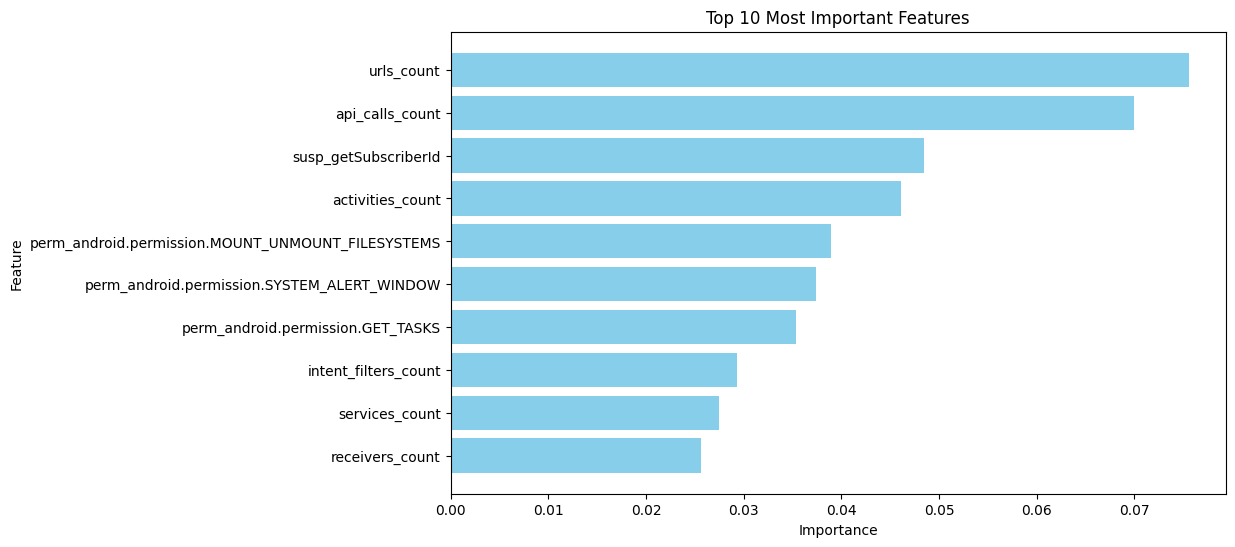

In [8]:
# Obtener las características más importantes
feature_importances = rf_model.feature_importances_

# Crear un DataFrame para visualizar las importancias
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Mostrar las 10 características más importantes
display(importance_df.head(10))

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

In [9]:
import seaborn as sns

# Estadísticas descriptivas de urls_count por label
urls_count_stats = df.groupby('label')['urls_count'].describe()
print(urls_count_stats)

         count       mean       std  min   25%   50%   75%     max
label                                                             
0      67771.0  44.890661  77.88022  0.0  17.0  30.0  51.0  6297.0
1       7519.0  48.302301  82.87415  0.0   0.0  15.0  61.0  1983.0


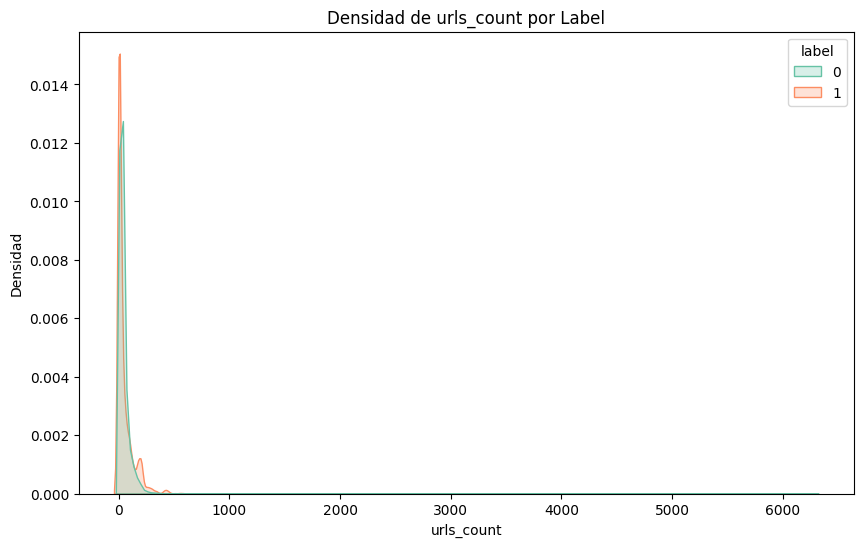

In [10]:
# Visualización de la densidad de urls_count por label
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='urls_count', hue='label', common_norm=False, fill=True, palette='Set2')
plt.title('Densidad de urls_count por Label')
plt.xlabel('urls_count')
plt.ylabel('Densidad')
plt.show()

C:\Users\alexg\AppData\Local\Temp\ipykernel_18564\821809998.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='label', y='urls_count', palette='Set2')


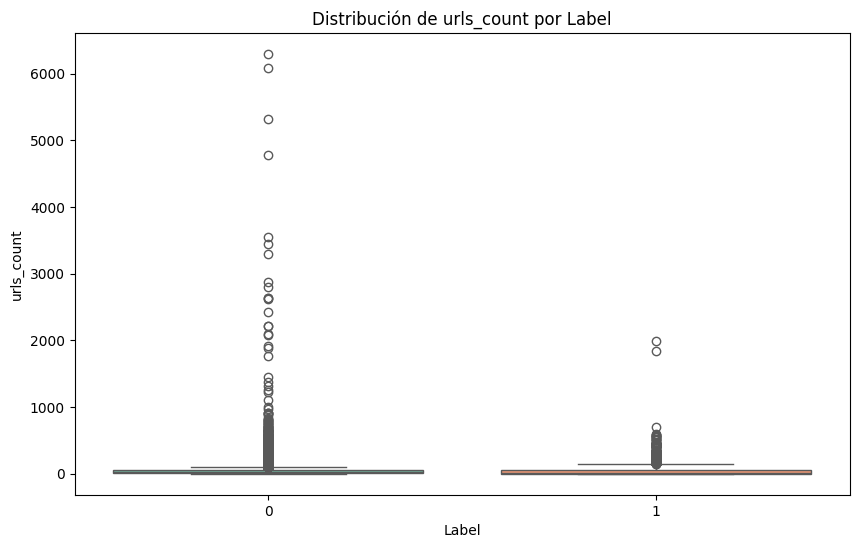

In [11]:
# Visualización de la distribución de urls_count por label
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='label', y='urls_count', palette='Set2')
plt.title('Distribución de urls_count por Label')
plt.xlabel('Label')
plt.ylabel('urls_count')
plt.show()

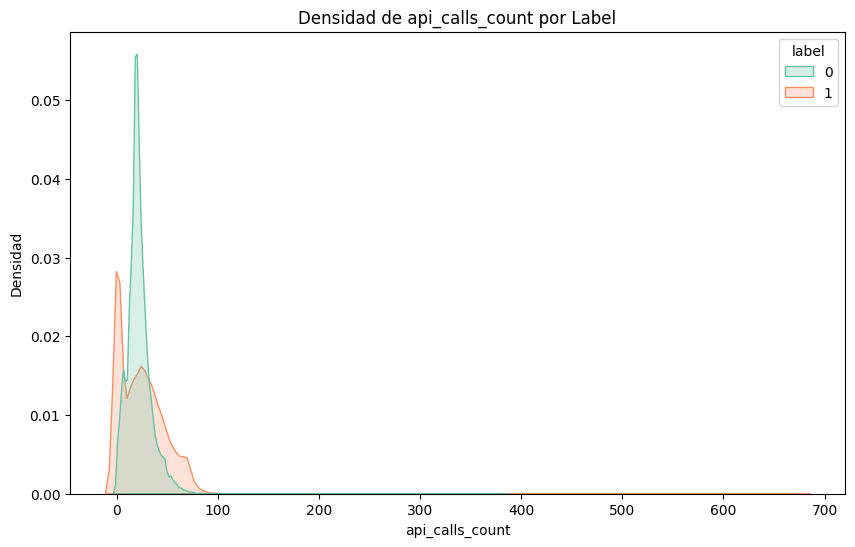

In [12]:
# Visualización de la densidad de urls_count por label
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='api_calls_count', hue='label', common_norm=False, fill=True, palette='Set2')
plt.title('Densidad de api_calls_count por Label')
plt.xlabel('api_calls_count')
plt.ylabel('Densidad')
plt.show()

C:\Users\alexg\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


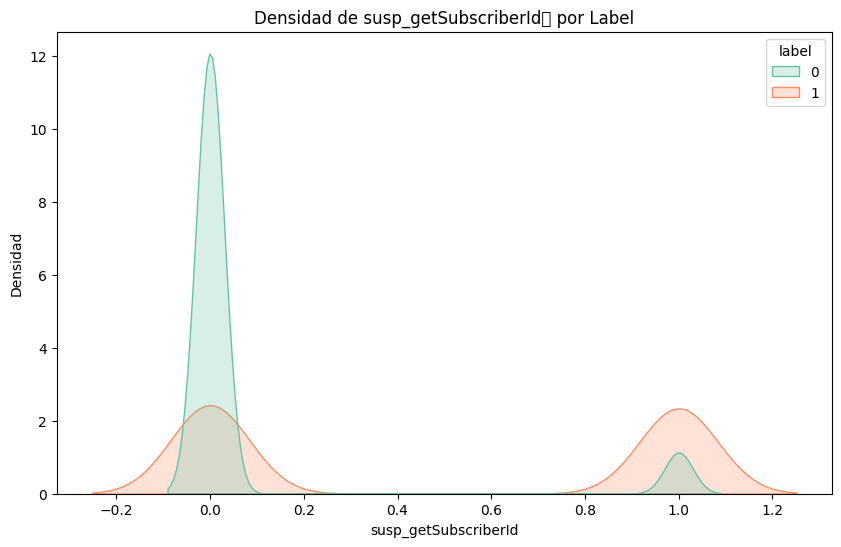

In [13]:
# Visualización de la densidad de urls_count por label
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='susp_getSubscriberId', hue='label', common_norm=False, fill=True, palette='Set2')
plt.title('Densidad de susp_getSubscriberId	 por Label')
plt.xlabel('susp_getSubscriberId')
plt.ylabel('Densidad')
plt.show()

In [14]:
mean_api_calls_count_label_0 = df[df['label'] == 0]['api_calls_count'].mean()
mean_urls_count_label_0 = df[df['label'] == 0]['urls_count'].mean()
mean_susp_getSubscriberId_label_0 = df[df['label'] == 0]['susp_getSubscriberId'].mean()

print(f"Mean of api_calls_count when label is 0: {mean_api_calls_count_label_0}")
print(f"Mean of urls_count when label is 0: {mean_urls_count_label_0}")
print(f"Mean of susp_getSubscriberId when label is 0: {mean_susp_getSubscriberId_label_0}")

Mean of api_calls_count when label is 0: 21.575231293621165
Mean of urls_count when label is 0: 44.89066119726727
Mean of susp_getSubscriberId when label is 0: 0.08549379528116746


# 1. Perform at least one black-box attack and one white-box attack on the model. You may perform additional attacks as desired.

- Black box
- White box

## Black Box

In [20]:
import numpy as np

# Function to perform a black-box attack by perturbing the input features
def black_box_attack(sample, epsilon=0.1):
    """
    Perform a black-box attack by adding small perturbations to the input features.
    
    Parameters:
    - model: Trained model to attack
    - sample: Input sample (DataFrame) to perturb
    - epsilon: Magnitude of the perturbation
    
    Returns:
    - perturbed_sample: Perturbed input sample
    """
    # Convert the sample to a numpy array
    sample_array = sample.values.astype(float)
    
    # Generate random noise within the range [-epsilon, epsilon]
    noise = np.random.uniform(-epsilon, epsilon, sample_array.shape)
    
    # Add the noise to the sample
    perturbed_sample = sample_array + noise
    
    # Ensure the perturbed sample remains non-negative
    perturbed_sample = np.clip(perturbed_sample, 0, None)
    
    return sample.copy().assign(**{col: perturbed_sample[0][i] for i, col in enumerate(sample.columns)})

# Select a sample from the test set
sample_index = 0  # Change this index to select different samples
original_sample = X_test.iloc[sample_index:sample_index + 1]

# Perform the black-box attack
epsilon = 20  # Magnitude of perturbation
perturbed_sample = black_box_attack(original_sample.copy(), epsilon)

# Predict the label for the original and perturbed samples
original_prediction = rf_model.predict(original_sample)[0]
perturbed_prediction = rf_model.predict(perturbed_sample)[0]

# Print the results
print("Original Sample Prediction:", original_prediction)
print("Perturbed Sample Prediction:", perturbed_prediction)
print("Ground Truth Label:", y_test.iloc[sample_index])

Original Sample Prediction: 1
Perturbed Sample Prediction: 0
Ground Truth Label: 1


## White Box

In [16]:
# Seleccionar una fila del conjunto de prueba
sample_index = 0  # Cambia este índice para probar con diferentes filas
sample_row = X_test.iloc[sample_index:sample_index + 1]

atack_sample_row = X_test.iloc[sample_index:sample_index + 1].copy()
atack_sample_row["urls_count"] = round(mean_urls_count_label_0)
atack_sample_row["api_calls_count"] = round(mean_api_calls_count_label_0)
atack_sample_row["susp_getSubscriberId"] = round(mean_susp_getSubscriberId_label_0)

# Mostrar la fila seleccionada
print("Sample Row:")
print(sample_row[['urls_count', 'api_calls_count', 'susp_getSubscriberId']])
print("\nAtack Sample Row:")
print(atack_sample_row[['urls_count', 'api_calls_count', 'susp_getSubscriberId']])

# Realizar la predicción
predicted_label = rf_model.predict(sample_row)[0]
atack_label = rf_model.predict(atack_sample_row)[0]

# Obtener el ground truth
ground_truth_label = y_test.iloc[sample_index]

# Imprimir los resultados
print(f"\nPredicted Label: {predicted_label}")
print(f"Atack Predicted Label: {atack_label}")
print(f"Ground Truth Label: {ground_truth_label}")

Sample Row:
      urls_count  api_calls_count  susp_getSubscriberId
5607          13               22                     1

Atack Sample Row:
      urls_count  api_calls_count  susp_getSubscriberId
5607          45               22                     0

Predicted Label: 1
Atack Predicted Label: 0
Ground Truth Label: 1


# 2. Prove that your model can be more robust to adversarial examples

Demonstrate that your model maintains high accuracy when subjected to adversarial examples. Provide empirical evidence of robustness by evaluating performance under adversarial attacks.

What Will Be Valued:
- Effective adversarial attack methods and proper defense mechanisms.
- Clear evaluation metrics comparing standard vs. adversarial performance.
- Well-documented methodology and reproducibility of results.

# 3. Try to attack this model

You will be given the anonymous model `android_permission_model.onnx`, previously trained on the provided dataset. 
Analyze the model’s weaknesses by testing different black-box attack strategies.

What Will Be Valued:
- Use of diverse adversarial attack techniques.
- Quantitative analysis of attack effectiveness with relevant metrics.
- Clear documentation of the attack process and reproducibility.

Below, you can find an example on model loading and inference. The model expects every column in the dataset except for `sha256`, `timestamp` and `unused_permissions`.
The model is loaded in an [onnx runtime](https://onnxruntime.ai/docs/api/python/api_summary.html). 

In [1]:
import os
import numpy as np
import pandas as pd
import onnxruntime as rt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

DATASET_ROUTE = './dataset.csv'

df = pd.read_csv(DATASET_ROUTE)
model_path = 'android_permission_model.onnx'

# removing unused columns
if 'timestamp' in df.columns:
    df = df.drop('timestamp', axis=1)
if 'unused_permissions' in df.columns:
    df = df.drop('unused_permissions', axis=1)
if 'sha256' in df.columns:
    df = df.drop('sha256', axis=1)

# features and target separation + train/test split
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

Example inference function using [sess.run()](https://onnxruntime.ai/docs/api/python/api_summary.html#onnxruntime.InferenceSession.run):

In [2]:
def onnx_inference(model_path, test_data):
    """
    Function to load and make predictions with an ONNX model
    """
    # open ONNX inference session
    sess = rt.InferenceSession(model_path)
    
    # input and output names
    input_name = sess.get_inputs()[0].name
    output_names = [output.name for output in sess.get_outputs()]
    
    # send inputs to the model and obtain predictions
    results = sess.run(output_names, {input_name: test_data.astype(np.float32)})

    return results[0]       # results[0] are discrete predicted labels, while results[1] are probabilities

In [6]:
# try and load the model
if not os.path.exists(model_path):
    print(f"Error: Model file '{model_path}' not found!")
    print(f"Current working directory: {os.getcwd()}")
    print(f"Files in current directory: {os.listdir('.')}")
else:
    # small sample to test if it works
    test_sample = X_test.iloc[:5].values
    onnx_predictions = onnx_inference(model_path, test_sample)
    
    if onnx_predictions is not None:
        print("\nONNX Model Predictions (sample):")
        print(onnx_predictions)
        
        # compare with actual labels
        actual_labels = y_test.iloc[:5].values
        print("\nActual labels:")
        print(actual_labels)
    
    # full test set now
    print("\nONNX Model Predictions (full test set):")
    full_predictions = onnx_inference(model_path, X_test.values)

    try:
        print(f"Accuracy: {accuracy_score(y_test, full_predictions):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, full_predictions))
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, full_predictions))
    except Exception as e:
        print(f"Error during ONNX prediction: {e}")


ONNX Model Predictions (sample):
[1 0 0 0 1]

Actual labels:
[1 0 0 0 0]

ONNX Model Predictions (full test set):
Accuracy: 0.9815

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     16943
           1       0.86      0.97      0.91      1880

    accuracy                           0.98     18823
   macro avg       0.93      0.98      0.95     18823
weighted avg       0.98      0.98      0.98     18823


Confusion Matrix:
[[16642   301]
 [   48  1832]]


In [7]:
X_train.columns

Index(['activities_count', 'providers_count', 'receivers_count',
       'features_count', 'intent_filters_count', 'api_calls_count',
       'urls_count', 'services_count',
       'perm_android.permission.ACCESS_ALL_DOWNLOADS',
       'perm_android.permission.ACCESS_BLUETOOTH_SHARE',
       ...
       'susp_getNetworkCountryIso', 'susp_getPackageInfo',
       'susp_getSimCountryIso', 'susp_getSubscriberId',
       'susp_getSystemService', 'susp_getWifiState', 'susp_sendTextMessage',
       'susp_setWifiDisabled', 'susp_setWifiEnabled', 'susp_system/bin/su'],
      dtype='object', length=354)

In [13]:
# Generate synthetic data with proper handling of one-hot encoded columns
def generate_synthetic_data_with_one_hot(model_path, num_samples, feature_columns):
    """
    Generate synthetic data using the surrogate model, ensuring proper handling of one-hot encoded columns.
    
    Parameters:
    - surrogate_model: Trained surrogate model
    - num_samples: Number of synthetic samples to generate
    - feature_columns: List of feature column names
    
    Returns:
    - synthetic_data: DataFrame containing synthetic data
    """
    # Separate columns into `_count` and one-hot encoded columns
    count_columns = [col for col in feature_columns if col.endswith('_count')]
    one_hot_columns = [col for col in feature_columns if not col.endswith('_count')]
    
    # Generate random values for `_count` columns
    count_data = np.random.randint(0, 100, size=(num_samples, len(count_columns)))
    
    # Generate random one-hot encoded values
    one_hot_data = np.random.choice([0, 1], size=(num_samples, len(one_hot_columns)))
    
    # Combine all data into a single DataFrame
    synthetic_features = pd.DataFrame(
        np.hstack([count_data, one_hot_data]),
        columns=count_columns + one_hot_columns
    )
    
    # Predict labels using the surrogate model
    # Use the ONNX model for inference
    synthetic_labels = onnx_inference(model_path, synthetic_features.values)
    
    # Add the labels to the synthetic data
    synthetic_features['label'] = synthetic_labels
    
    return synthetic_features

In [ ]:
from sklearn.ensemble import RandomForestClassifier

surrogate_model = RandomForestClassifier(random_state=42)

# Generate synthetic data
num_synthetic_samples = 10_000
synthetic_data = generate_synthetic_data_with_one_hot(model_path, num_synthetic_samples, X_train.columns)

# Train the surrogate model using synthetic data
X_synthetic = synthetic_data.drop('label', axis=1)
y_synthetic = synthetic_data['label']

surrogate_model.fit(X_synthetic, y_synthetic)

# Evaluate the surrogate model on the test set
surrogate_predictions = surrogate_model.predict(X_test)
print("Surrogate Model Evaluation with Synthetic Data:")
print(classification_report(y_test, surrogate_predictions))

Surrogate Model Evaluation with Synthetic Data:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     16943
           1       0.61      0.51      0.56      1880

    accuracy                           0.92     18823
   macro avg       0.78      0.74      0.76     18823
weighted avg       0.91      0.92      0.92     18823



In [26]:
def black_box_attack_with_surrogate(surrogate_model, onnx_model_path, test_data, feature_columns, epsilon=0.1):
    """
    Perform a black-box attack using the surrogate model to generate adversarial examples,
    taking into account one-hot encoded and range-based columns.
    
    Parameters:
    - surrogate_model: Trained surrogate model
    - onnx_model_path: Path to the ONNX model
    - test_data: Original test data (DataFrame)
    - feature_columns: List of feature column names
    - epsilon: Magnitude of the perturbation
    
    Returns:
    - adversarial_data: Adversarial examples (DataFrame)
    - original_predictions: Predictions of the ONNX model on the original test data
    - adversarial_predictions: Predictions of the ONNX model on the adversarial examples
    """
    # Separate columns into one-hot and range-based
    range_columns = [col for col in feature_columns if col.endswith('_count')]
    one_hot_columns = [col for col in feature_columns if col not in range_columns]
    
    # Predict probabilities using the surrogate model
    surrogate_probs = surrogate_model.predict_proba(test_data)
    
    # Generate perturbations for range-based columns
    perturbations = epsilon * np.sign(surrogate_probs[:, 1].reshape(-1, 1) - 0.5)
    range_perturbations = perturbations[:, :len(range_columns)]
    
    # Generate adversarial examples for range-based columns
    adversarial_range_data = test_data[range_columns].values + range_perturbations
    adversarial_range_data = np.clip(adversarial_range_data, 0, 100)  # Ensure valid range
    
    # For one-hot columns, randomly flip one-hot values
    adversarial_one_hot_data = test_data[one_hot_columns].values.copy()
    flip_indices = np.random.choice(adversarial_one_hot_data.shape[1], size=adversarial_one_hot_data.shape[0])
    for i, idx in enumerate(flip_indices):
        adversarial_one_hot_data[i, idx] = 1 - adversarial_one_hot_data[i, idx]  # Flip 0 to 1 or 1 to 0
    
    # Combine range-based and one-hot adversarial data
    adversarial_data = np.hstack([adversarial_range_data, adversarial_one_hot_data])
    
    # Get predictions from the ONNX model
    original_predictions = onnx_inference(onnx_model_path, test_data.values)
    adversarial_predictions = onnx_inference(onnx_model_path, adversarial_data)
    
    return adversarial_data, original_predictions, adversarial_predictions

# Perform the black-box attack
epsilon = 4  # Magnitude of perturbation
adversarial_data, original_predictions, adversarial_predictions = black_box_attack_with_surrogate(
    surrogate_model, model_path, X_test, X_train.columns, epsilon
)

# Evaluate the attack
print("Original ONNX Model Accuracy:", accuracy_score(y_test, original_predictions))
print("Adversarial ONNX Model Accuracy:", accuracy_score(y_test, adversarial_predictions))
print("\nConfusion Matrix (Adversarial):")
print(confusion_matrix(y_test, adversarial_predictions))

Original ONNX Model Accuracy: 0.9814588535302555
Adversarial ONNX Model Accuracy: 0.961270785740849

Confusion Matrix (Adversarial):
[[16546   397]
 [  332  1548]]


In [46]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

# Define a range of epsilon values to test
epsilon_values = [0, 1, 2, 4, 8, 16, 32, 64, 128]

# Initialize lists to store metrics
accuracies = []
precision_scores = []
recall_scores = []

original_predictions = onnx_inference(model_path, X_test.values)
original_accuracy = accuracy_score(y_test, original_predictions)
original_precision = precision_score(y_test, original_predictions, average='weighted', zero_division=0)
original_recall = recall_score(y_test, original_predictions, average='weighted', zero_division=0)

# Evaluate the model for each epsilon value
for epsilon in epsilon_values:
    adversarial_data, _, adversarial_predictions = black_box_attack_with_surrogate(
        surrogate_model, model_path, X_test, X_train.columns, epsilon
    )
    
    accuracies.append(accuracy_score(y_test, adversarial_predictions))
    precision_scores.append(precision_score(y_test, adversarial_predictions, average='weighted', zero_division=0))
    recall_scores.append(recall_score(y_test, adversarial_predictions, average='weighted', zero_division=0))

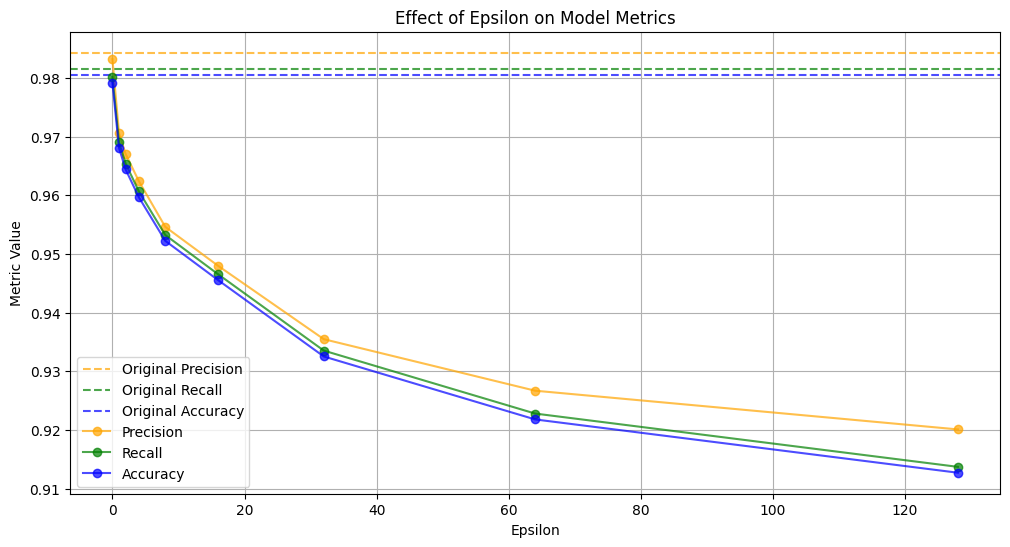

In [50]:
plt.figure(figsize=(12, 6))

# Define a small offset to avoid overlapping lines
offset = 0.001

# Plot original scores as dotted lines with slight offsets
plt.axhline(original_precision + offset, color='orange', linestyle='--', label='Original Precision', alpha=0.7)
plt.axhline(original_recall, color='green', linestyle='--', label='Original Recall', alpha=0.7)
plt.axhline(original_accuracy - offset, color='blue', linestyle='--', label='Original Accuracy', alpha=0.7)

# Plot metrics for different epsilon values
plt.plot(epsilon_values, np.array(precision_scores) + offset, label='Precision', marker='o', color='orange', alpha=0.7)
plt.plot(epsilon_values, np.array(recall_scores), label='Recall', marker='o', color='green', alpha=0.7)
plt.plot(epsilon_values, np.array(accuracies) - offset, label='Accuracy', marker='o', color='blue', alpha=0.7)

# Add labels, legend, and grid
plt.title('Effect of Epsilon on Model Metrics')
plt.xlabel('Epsilon')
plt.ylabel('Metric Value')
plt.legend()
plt.grid()
plt.show()